In [1]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
import qiskit.providers as providers
#from qiskit import provider
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD, HartreeFock
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer,FreezeCoreTransformer
from qiskit.utils import algorithm_globals
from qiskit.algorithms.eigensolvers import VQD
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit import IBMQ

In [3]:
job=provider.runtime.job('cghdft1aq6069bbad5n0')

In [4]:
def dipole_moment(cyclic,charge,mult):

  algorithm_globals.random_seed = 1024

  molecule = Molecule(geometry=cyclic,
                              charge=charge, 
                              multiplicity=mult)
  ### Defining the driver
  driver = ElectronicStructureMoleculeDriver(molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF) # This is an example of using STO-3G basis set, and performing preliminary Quantum Chemistry calculation using PySCF
  
  problem_reduced = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])
  second_q_ops_reduced = problem_reduced.second_q_ops()

  # Set the mapper to qubits
  mapper = JordanWignerMapper() # This is the example of parity mapping

  # Set the qubit converter with two qubit reduction to reduce the computational cost 
  converter = QubitConverter(mapper,z2symmetry_reduction='auto')    

  # Compute the Hamitonian in qubit form
  qubit_op_parity = converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), sector_locator=problem_reduced.symmetry_sector_locator)

  init_state = HartreeFock(num_spin_orbitals=problem_reduced.num_spin_orbitals, num_particles=problem_reduced.num_particles , qubit_converter= converter)

  vqe_factory = VQEUCCFactory(quantum_instance=backend_2,optimizer=L_BFGS_B(maxiter=50),ansatz=UCC(qubit_converter=converter, num_particles=problem_reduced.num_particles,num_spin_orbitals=problem_reduced.num_spin_orbitals,excitations='sd')) # This is an example of UCC"SD" ansatz
  #print('1')
  solver = GroundStateEigensolver(converter, vqe_factory)
  #print('2')    
  result = solver.solve(problem_reduced)    
  #print('3')

  dip=[abs(i) for i in result.dipole_moment_in_debye[0] if i is not None]
  dip_tot = sum(dip)
  min_energy = result.total_energies[0]

  return dip_tot,min_energy

In [5]:
dip = []
Energy =[]
dist = np.linspace(0.2,3.2,25)
Charge = 0
Multiplicity = 1
for i in dist:
    cyclic = [["H",[0.000,0.9616,-0.8239]],
          ["S",[0.0000,0.000,0.1030]],
          ["H",[0.0000,-0.9616,-i]]]
    dipole,energy = dipole_moment(cyclic,Charge,Multiplicity)
    Energy.append(energy)
    dip.append(dipole)
    print('Dipole (debye) for '+str(i)+' : ', dipole)
    print('Energy : ', energy)

Dipole (debye) for 0.2 :  1.6870893442461674
Energy :  (-394.1939253048586+0j)
Dipole (debye) for 0.325 :  1.5383041980388639
Energy :  (-394.2444890319046+0j)
Dipole (debye) for 0.45 :  1.3945983058851477
Energy :  (-394.28968660044416+0j)
Dipole (debye) for 0.575 :  1.249484736498013
Energy :  (-394.3240427523408+0j)
Dipole (debye) for 0.7 :  1.097717143476773
Energy :  (-394.34532854625473+0j)
Dipole (debye) for 0.825 :  0.93831528404805
Energy :  (-394.3539418829879+0j)
Dipole (debye) for 0.95 :  0.925342435009509
Energy :  (-394.351869656286+0j)
Dipole (debye) for 1.075 :  0.9157501494536124
Energy :  (-394.34176199773134+0j)
Dipole (debye) for 1.2 :  0.9062228507379286
Energy :  (-394.3263191178416+0j)
Dipole (debye) for 1.325 :  0.8947466075677437
Energy :  (-394.30797052162904+0j)
Dipole (debye) for 1.45 :  0.8813591243242789
Energy :  (-394.28874282027306+0j)
Dipole (debye) for 1.575 :  0.8673267333394967
Energy :  (-394.27021684053165+0j)
Dipole (debye) for 1.7 :  0.855045375

In [6]:
bond_length=[np.sqrt(0.9616**2+(0.1030+i)**2) for i in dist]

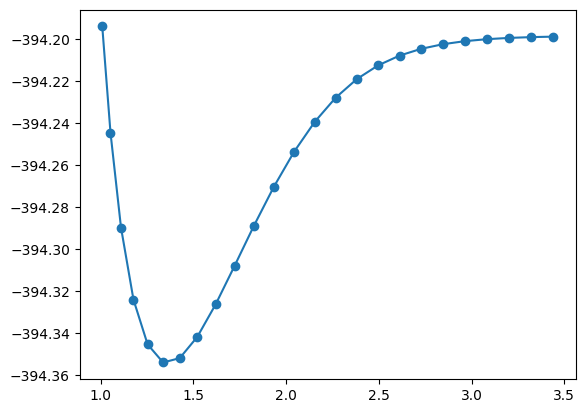

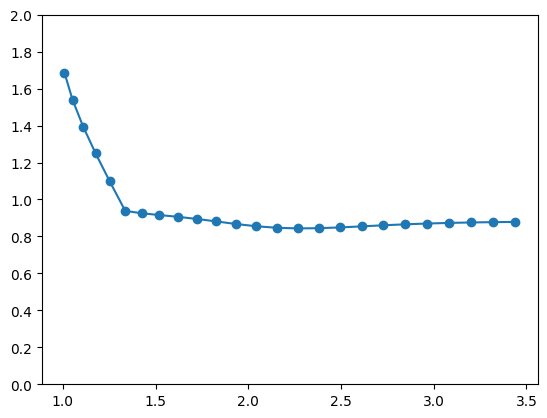

In [14]:
plt.plot(bond_length, Energy, '-o')
plt.show()
plt.plot(bond_length, dip, '-o')
plt.yticks(np.arange(0, 2.2,0.2))
plt.show()